In [1]:
import numpy as np
import pandas as pd
import ta
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
%matplotlib inline


from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyfolio as pf

C:\Users\juini\anaconda3\envs\py38\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
C:\Users\juini\anaconda3\envs\py38\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
symbols = ['EURUSDmicro','GBPUSDmicro','USDCHFmicro','USDJPYmicro','USDCADmicro']

timeframe = 'D1'

df = pd.read_csv("data/"+ symbols[1]+ timeframe+ ".csv")
df = df[['Date','Open','High','Low','Close']]
df['Date'] = pd.to_datetime(df['Date'])
df['Return'] =   df['Close'].pct_change() # Retorno percentual
df['Returnshift'] = df['Return'].shift(-1)
df['Alta/Baixa'] = [1 if x >= 0 else 0 for x in df['Return']] # dia de alta ou de baixa

df['A'] = df['High'] / df['Low']   # Razão entre a máxima e mínima do candle

df['B'] = (abs(df['Close'] - df['Open'])) / (df['High'] - df['Low'])  # Razão entre o corpo e a amplitude do candle

sombra1 = (df['High'] - df['Close']) / (df['Open'] - df['Low'])
sombra2 = (df['High'] - df['Open']) / (df['Close'] - df['Low'])

df['C'] = [sombra1.loc[x] if df.loc[x, 'Alta/Baixa'] == 1 else sombra2.loc[x] for x in df.index] # Razão entre a sombra superior e inferior

df['D'] = df['Close'] / df['Close'].shift(1) # Razão entre o fechamento de Hoje e o de x dias anteriores

df['E'] = df['Close'] - df['Close'].rolling(8).mean() # Distância entre o preço de hoje e a média curta

df['F'] = df['Close'] - df['Close'].rolling(80).mean() # Distância entre o preço de hoje e a média Longa

df['G'] = df['Close'].rolling(8).mean() - df['Close'].rolling(80).mean() # Distância entre o preço das duas médias

df['H'] = df['Return'].rolling(5).std() # Volatildiade dos últimos x dias

df['I'] = df['H'].rolling(5).sum() # Volatildiade acumulada dos últimos x dias

df['A2'] = df['A'].shift(1)
df['B2'] = df['B'].shift(1)
df['C2'] = df['C'].shift(1)
df.C.replace([np.inf, -np.inf], 0, inplace=True)
df.C2.replace([np.inf, -np.inf], 0, inplace=True)
df['D2'] = df['D'].shift(1)
df['E2'] = df['E'].shift(1)
df['F2'] = df['F'].shift(1)
df['G2'] = df['G'].shift(1)
df['H2'] = df['H'].shift(1)
df['I2'] = df['I'].shift(1)

df['Amplitude'] = df['Close'].shift(-1) - df['Close']

df['alvo'] = df['Alta/Baixa'].shift(-1)
df.dropna(inplace=True)

df.set_index ('Date', inplace = True)

df.head()

,Open,High,Low,Close,Return,Returnshift,Alta/Baixa,A,B,C,...,B2,C2,D2,E2,F2,G2,H2,I2,Amplitude,alvo
Date,,,,,,,,,,,,,,,,,,,,,
2013-04-23,1.52900,1.52958,1.51953,1.52374,-0.003414,0.001811,0,1.006614,0.523383,0.137767,...,0.650901,0.054422,1.003999,-0.001015,-0.016831,-0.015816,0.005598,0.025538,0.00276,1.0
2013-04-24,1.52376,1.52855,1.52249,1.52650,0.001811,0.010934,1,1.003980,0.452145,1.614173,...,0.523383,0.137767,0.996586,-0.004404,-0.020784,-0.016381,0.004962,0.026637,0.01669,1.0
2013-04-25,1.52658,1.54779,1.52632,1.54319,0.010934,0.002599,1,1.014067,0.773638,17.692308,...,0.452145,1.614173,1.001811,-0.000700,-0.016973,-0.016273,0.003450,0.024622,0.00401,1.0
2013-04-26,1.54334,1.54964,1.54169,1.54720,0.002599,0.001700,1,1.005157,0.485535,1.478788,...,0.773638,17.692308,1.010934,0.014124,0.000519,-0.013605,0.005912,0.025240,0.00263,1.0
2013-04-29,1.54857,1.55440,1.54747,1.54983,0.001700,0.002026,1,1.004478,0.181818,4.154545,...,0.485535,1.478788,1.002599,0.016738,0.005331,-0.011406,0.005159,0.025081,0.00314,1.0


In [3]:
indicador_bb = ta.volatility.BollingerBands(close = df['Close'], n = 20, ndev = 2, fillna = False)
indicador_rsi = ta.momentum.RSIIndicator(close = df['Close'], n = 14, fillna = False)
indicador_macd = ta.trend.MACD(close = df['Close'], n_slow = 26, n_fast = 12, n_sign = 9, fillna = False)

df['bb'] = indicador_bb.bollinger_pband()
df['bbH'] = indicador_bb.bollinger_hband_indicator() 
df['bbL'] = indicador_bb.bollinger_lband_indicator() 


df['rsi'] = indicador_rsi.rsi()
df['rsiH'] = [1 if x > 70  else 0 for x in indicador_rsi.rsi()]
df['rsiL'] = [1 if x < 30  else 0 for x in indicador_rsi.rsi()]

df['macd'] =  indicador_macd.macd_diff()
df['macdH'] =  [1 if x > 0 else 0 for x in indicador_macd.macd_diff()]
df['macdL'] =  [1 if x < 0 else 0 for x in indicador_macd.macd_diff()]

df.dropna(inplace=True)
#df

In [4]:
variaveis = [ 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2',
             'H2', 'I2','bb', 'bbH', 'bbL','rsi', 'rsiH', 'rsiL', 'macd', 'macdH', 'macdL']
X = df[variaveis]
y = df['alvo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
random = RandomForestClassifier()

In [6]:
random = random.fit(X_train,y_train)

In [7]:
resultadoRandom = random.predict(X_test)

In [8]:
from sklearn import metrics
print(metrics.classification_report(y_test,resultadoRandom))

              precision    recall  f1-score   support

         0.0       0.57      0.52      0.54       308
         1.0       0.49      0.54      0.51       263

    accuracy                           0.53       571
   macro avg       0.53      0.53      0.53       571
weighted avg       0.53      0.53      0.53       571



In [9]:
df['Predict'] = random.predict(X)

In [10]:
df['Bull'] = [df.loc[x, 'Amplitude'] if df.loc[x, 'Predict'] == 1 else 0 for x in df.index]

df['Bear'] = [ - df.loc[x, 'Amplitude'] if df.loc[x, 'Predict'] == 0 else 0 for x in df.index]

df['ResultCum'] = np.cumsum(df['Bull'] + df['Bear'])

In [11]:
df['ResultCum2'] = np.cumsum(df['Amplitude'])

In [12]:
df['Acertou'] =  [1 if df.loc[x, 'Predict'] == df.loc[x, 'alvo'] else 0 for x in df.index]
acc = np.mean(df['Acertou']==1)

print("acurácia",acc)

acurácia 0.8585699263932702


In [13]:
df.tail()

,Open,High,Low,Close,Return,Returnshift,Alta/Baixa,A,B,C,...,rsiL,macd,macdH,macdL,Predict,Bull,Bear,ResultCum,ResultCum2,Acertou
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-10,1.29986,1.30344,1.27721,1.28014,-0.015163,-0.000625,0,1.020537,0.751811,1.221843,...,0,-0.006144,0,1,1.0,-0.00080,0.0,7.74658,-0.27620,0
2020-09-11,1.28015,1.28639,1.27613,1.27934,-0.000625,0.003736,0,1.008040,0.078947,1.943925,...,0,-0.007032,0,1,1.0,0.00478,0.0,7.75136,-0.27142,1
2020-09-14,1.27780,1.29182,1.27673,1.28412,0.003736,0.003543,1,1.011819,0.418820,7.196262,...,0,-0.006968,0,1,1.0,0.00455,0.0,7.75591,-0.26687,1
2020-09-15,1.28396,1.29250,1.28139,1.28867,0.003543,0.006076,1,1.008670,0.423942,1.490272,...,0,-0.006310,0,1,1.0,0.00783,0.0,7.76374,-0.25904,1
2020-09-16,1.28827,1.30066,1.28740,1.29650,0.006076,0.000201,1,1.010300,0.620664,4.781609,...,0,-0.005090,0,1,1.0,0.00026,0.0,7.76400,-0.25878,1


In [14]:
df['ResultCum'].describe()

count    1902.000000
mean        3.912536
std         2.303666
min         0.001500
25%         1.714327
50%         4.212495
75%         5.959240
max         7.764000
Name: ResultCum, dtype: float64

In [15]:
df['Bull'].describe()

count    1902.000000
mean        0.001973
std         0.005114
min        -0.047690
25%         0.000000
50%         0.000000
75%         0.003500
max         0.037100
Name: Bull, dtype: float64

In [16]:
df['Bear'].describe()

count    1902.000000
mean        0.002109
std         0.005514
min        -0.024400
25%         0.000000
50%         0.000000
75%         0.003470
max         0.119050
Name: Bear, dtype: float64

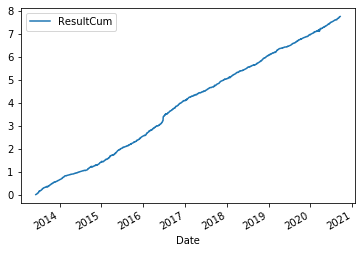

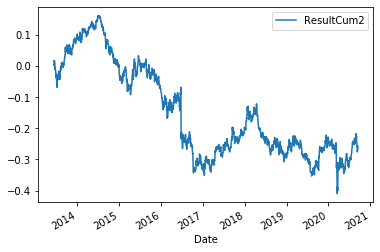

In [17]:
df.plot( y='ResultCum')
plt.show()
df.plot(y = 'ResultCum2')
plt.show()

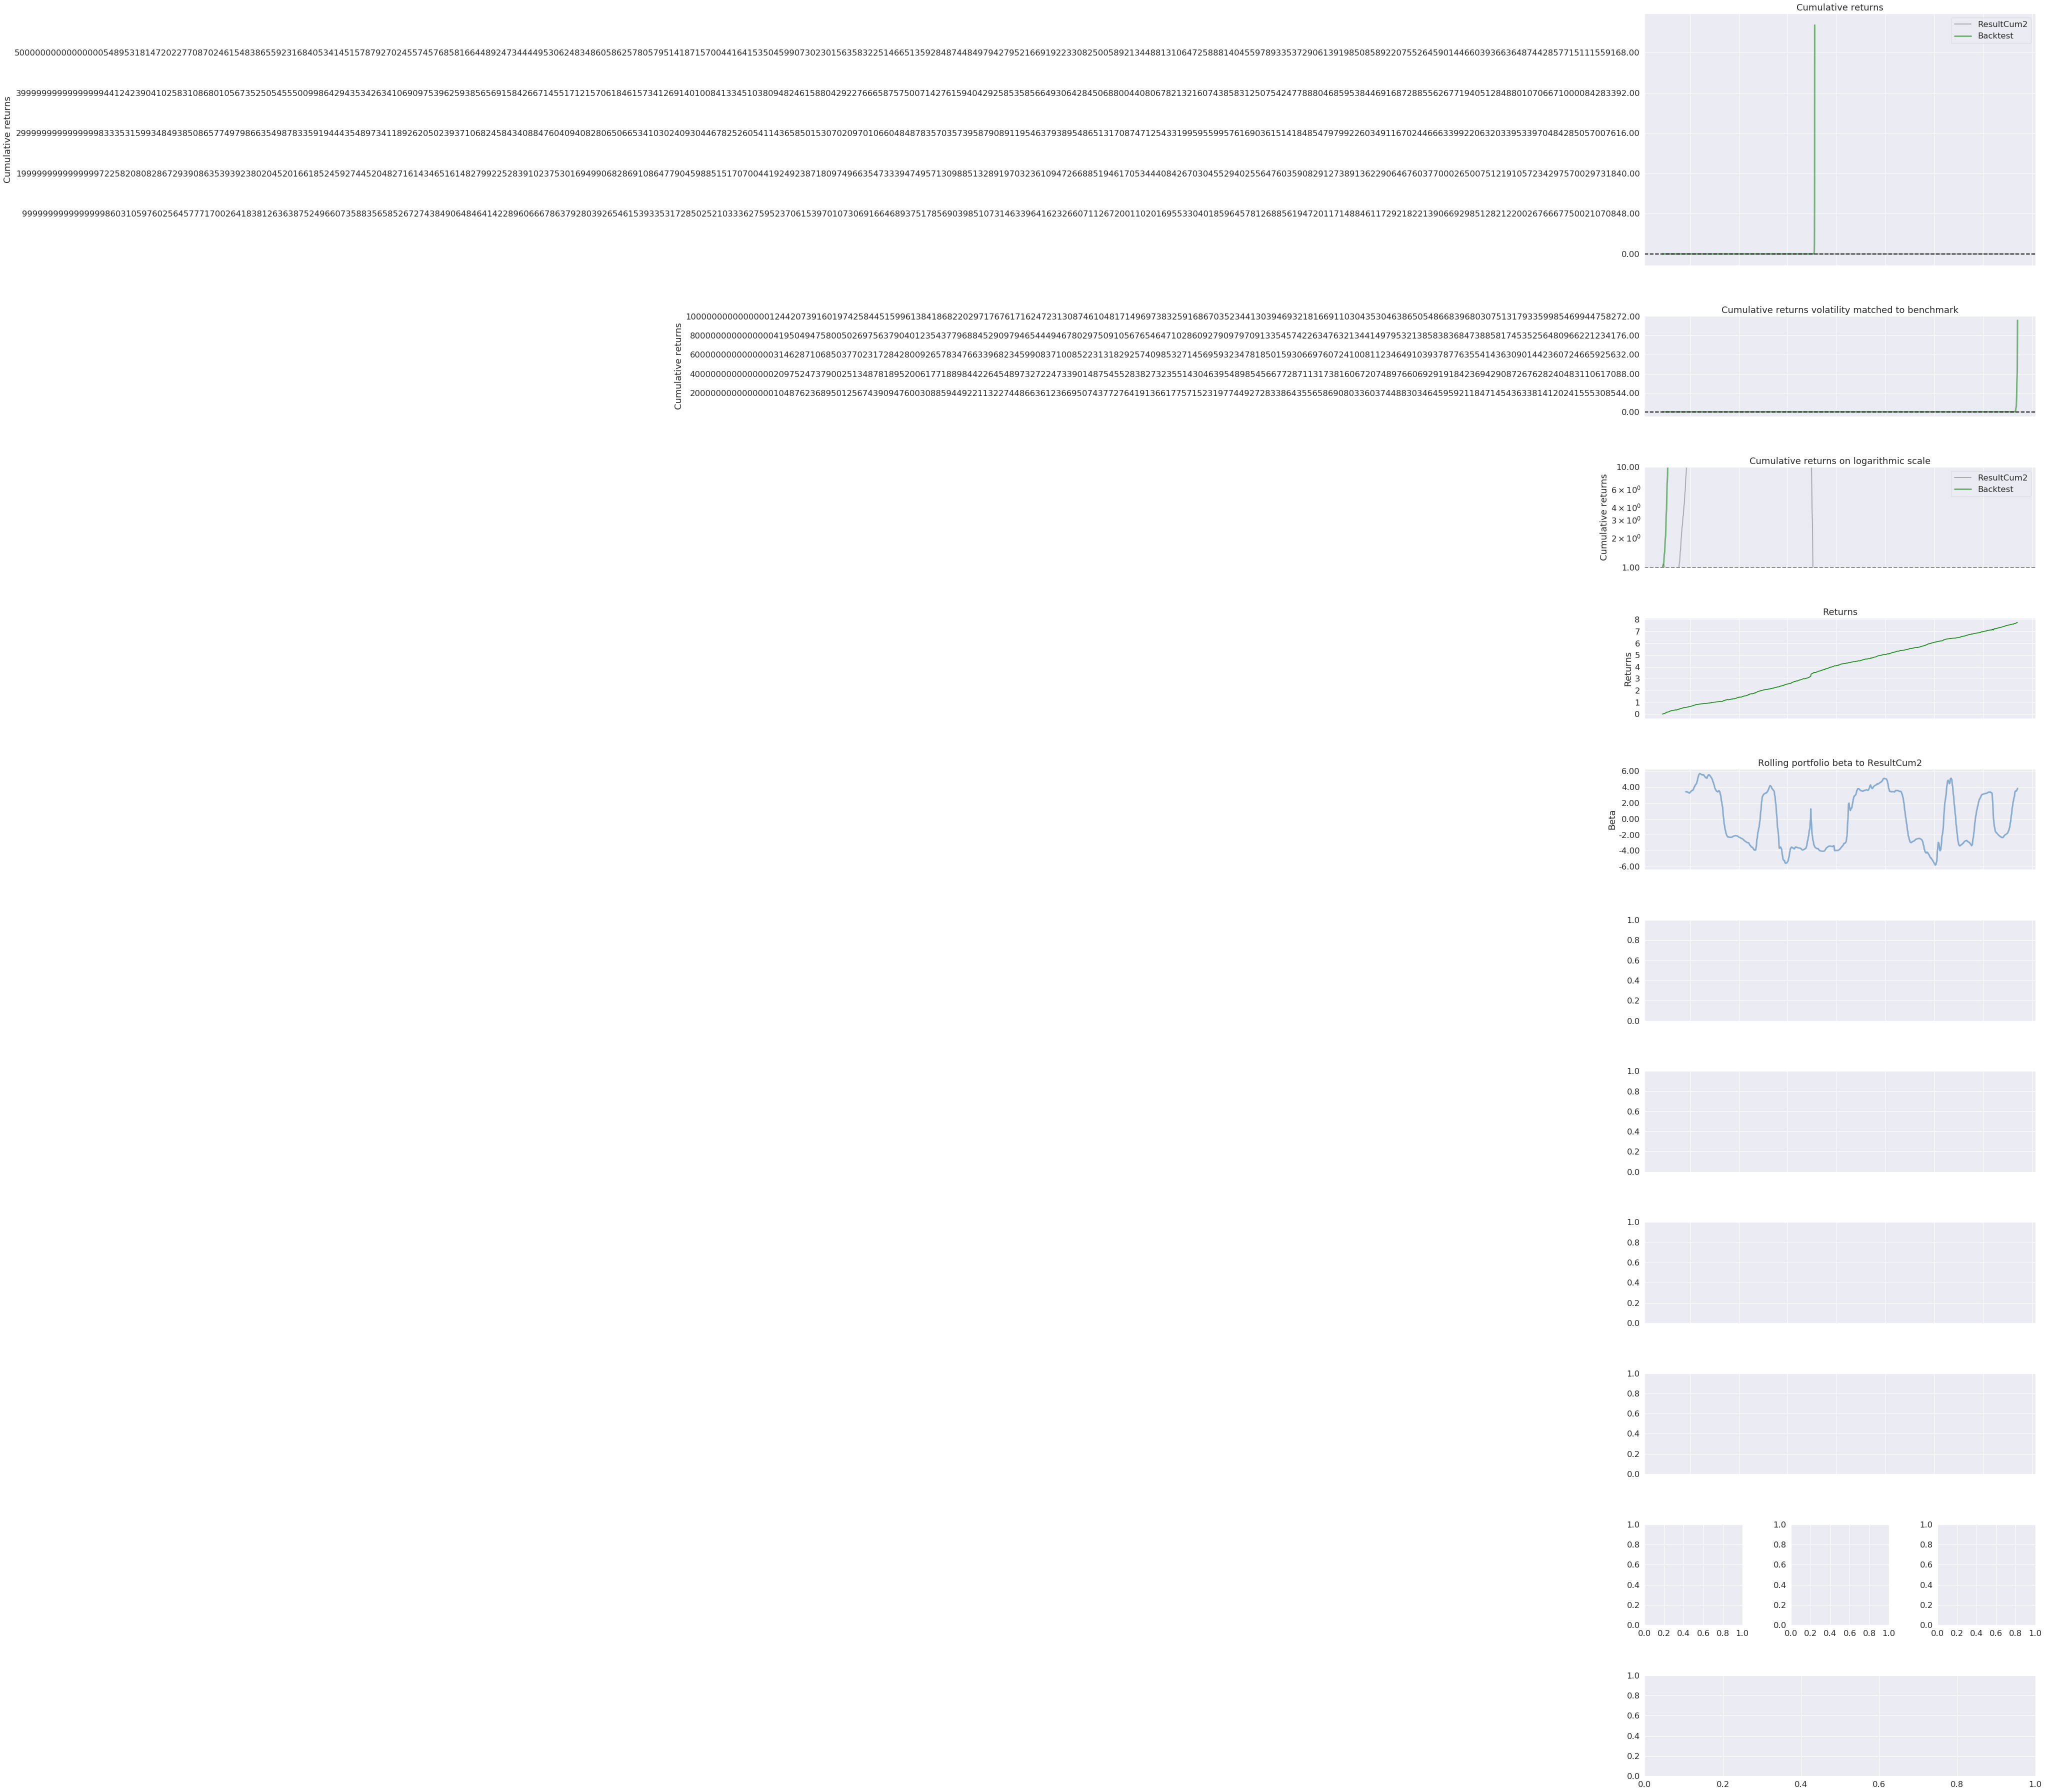

In [18]:
pf.create_full_tear_sheet(df["ResultCum"], benchmark_rets=df["ResultCum2"])